import library

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

load dataset

In [20]:
file_path = 'data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'

try:
    df= pd.read_csv(file_path)
    print("Dataset berhasil dimuat.")
    print(f"Bentuk dataset: {df.shape}")
    print("\nLima baris pertama dataset")
    print(df.head())
    print("\nInformasi dataset:")
    df.info()
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan file ada di direktori yang sama.")
    exit()

Dataset berhasil dimuat.
Bentuk dataset: (225745, 79)

Lima baris pertama dataset
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                        

3.Preprocessing Data    

In [21]:
# --- 4.1. Pembersihan Nama Kolom ---
# Menghilangkan spasi di awal/akhir nama kolom
df.columns = df.columns.str.strip()

# --- 4.2. Menghapus Duplikasi ---
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"\nJumlah baris setelah menghapus duplikasi: {df.shape[0]} (Dihapus: {initial_rows - df.shape[0]} duplikasi)")

# --- 4.3. Menangani Nilai Tak Terbatas (Infinity) dan NaN ---
# Mengganti nilai infinity dengan NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Kolom 'Flow Bytes/s' dan 'Flow Packets/s' seringkali menjadi masalah
# Pastikan tipe data numerik dan tangani NaN yang mungkin muncul dari konversi
# Gunakan errors='coerce' untuk mengubah nilai yang tidak dapat dikonversi menjadi NaN
df['Flow Bytes/s'] = pd.to_numeric(df['Flow Bytes/s'], errors='coerce')
df['Flow Packets/s'] = pd.to_numeric(df['Flow Packets/s'], errors='coerce')

# Mengidentifikasi kolom numerik untuk imputasi
# Exclude 'Label' dan 'Label_Encoded' agar tidak terimputasi
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'Label_Encoded' in numeric_cols:
    numeric_cols.remove('Label_Encoded')
if 'Label' in numeric_cols:
    numeric_cols.remove('Label')

# Menggunakan SimpleImputer untuk mengisi nilai NaN dengan mean
imputer_numeric = SimpleImputer(strategy='mean')
# Pastikan hanya kolom yang ada di dataframe yang diimputasi
cols_to_impute = [col for col in numeric_cols if col in df.columns]
df[cols_to_impute] = imputer_numeric.fit_transform(df[cols_to_impute])

print(f"\nJumlah nilai hilang setelah imputasi: {df.isnull().sum().sum()}")
# Memastikan tidak ada NaN yang tersisa di kolom target jika ada, penting untuk LabelEncoder
df.dropna(subset=['Label'], inplace=True)


# --- 4.4. Encoding Kolom Target ('Label') ---
# Kolom 'Label' adalah kategorikal ('BENIGN', 'DDoS') dan perlu diubah menjadi numerik.
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])

print(f"\nDistribusi label setelah encoding:")
print(pd.Series(df['Label_Encoded']).value_counts())
print(f"Mapping label: {list(le.classes_)} -> {np.unique(df['Label_Encoded'])}")


# --- 4.5. Memisahkan Fitur (X) dan Target (y) ---
# Hapus kolom asli 'Label' dan kolom 'Label_Encoded' dari fitur X
# Kita menggunakan kolom 'Label_Encoded' sebagai target y
X = df.drop(['Label', 'Label_Encoded'], axis=1)
y = df['Label_Encoded']


# --- 4.6. Pembagian Data menjadi Set Pelatihan dan Pengujian ---
# Menggunakan StratifiedKFold untuk memastikan proporsi kelas yang sama di train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nUkuran data latih (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Ukuran data pengujian (X_test, y_test): {X_test.shape}, {y_test.shape}")

print("\nDistribusi kelas di data latih:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nDistribusi kelas di data pengujian:")
print(pd.Series(y_test).value_counts(normalize=True))


Jumlah baris setelah menghapus duplikasi: 223112 (Dihapus: 2633 duplikasi)

Jumlah nilai hilang setelah imputasi: 0

Distribusi label setelah encoding:
Label_Encoded
1    128016
0     95096
Name: count, dtype: int64
Mapping label: ['BENIGN', 'DDoS'] -> [0 1]

Ukuran data latih (X_train, y_train): (178489, 78), (178489,)
Ukuran data pengujian (X_test, y_test): (44623, 78), (44623,)

Distribusi kelas di data latih:
Label_Encoded
1    0.573772
0    0.426228
Name: proportion, dtype: float64

Distribusi kelas di data pengujian:
Label_Encoded
1    0.573785
0    0.426215
Name: proportion, dtype: float64


4.model dan latih

In [22]:
# --- 5.1. Mendefinisikan Model dalam Pipeline ---

# Pipeline untuk Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# Pipeline untuk Gaussian Naive Bayes
pipeline_gnb = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

# Pipeline untuk MLPClassifier (Neural Network)
pipeline_mlp = Pipeline([ # Mengoreksi 'pipleine_mlp' menjadi 'pipeline_mlp'
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, activation="relu", solver="adam", random_state=42, verbose=False, early_stopping=True))
])

# Daftar model untuk iterasi
models = {
    "Random Forest": pipeline_rf,
    "Gaussian Naive Bayes": pipeline_gnb,
    "Neural Network (MLP)": pipeline_mlp
}

# --- 5.2. Melatih dan Mengevaluasi Setiap Model ---
# Inisialisasi dictionary di sini, di cakupan yang benar agar dapat diakses oleh semua bagian.
results = {}
f1_scores_ddos = {}

# Dapatkan index untuk kelas 'DDoS'
ddos_label_encoded_value = None
if 'DDoS' in le.classes_:
    ddos_label_encoded_value = le.transform(['DDoS'])[0]
else:
    print("Peringatan: Kelas 'DDoS' tidak ditemukan dalam LabelEncoder. F1-score DDoS mungkin tidak akurat.")
    # Fallback ke nilai 1 jika 'DDoS' adalah kelas minoritas yang umum di-encode sebagai 1
    if len(le.classes_) > 1 and np.sum(y_train == 1) < np.sum(y_train == 0): # Contoh heuristik
        ddos_label_encoded_value = 1
    elif len(le.classes_) > 0: # jika hanya ada satu kelas, atau kelas lain
        ddos_label_encoded_value = 0 # Asumsi jika hanya ada benign

for model_name, pipeline in models.items():
    print(f"\n--- Melatih {model_name} ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Simpan hasil prediksi untuk evaluasi nantinya
    results[model_name] = y_pred

    print(f"Pelatihan {model_name} Selesai.")
    print(f"Evaluasi Awal {model_name}:")
    print(f"Akurasi: {accuracy_score(y_test, y_pred):.4f}")
    
    # Hitung F1-Score khusus untuk kelas 'DDoS' jika labelnya ditemukan
    if ddos_label_encoded_value is not None:
        f1_ddos = f1_score(y_test, y_pred, pos_label=ddos_label_encoded_value, zero_division=0)
        f1_scores_ddos[model_name] = f1_ddos
        print(f"F1-Score (DDoS): {f1_ddos:.4f}")
    else:
        print("F1-Score (DDoS) tidak dapat dihitung karena label 'DDoS' tidak teridentifikasi.")

    # --- Cross-validation ---
    print(f"Melakukan Cross-validation untuk {model_name}...")
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Gunakan 'f1_weighted' untuk F1-score rata-rata yang memperhitungkan ketidakseimbangan kelas
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1_weighted', n_jobs=-1)
    print(f"F1-score (Cross-Validation) untuk {model_name}: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")


--- Melatih Random Forest ---
Pelatihan Random Forest Selesai.
Evaluasi Awal Random Forest:
Akurasi: 0.9998
F1-Score (DDoS): 0.9998
Melakukan Cross-validation untuk Random Forest...
F1-score (Cross-Validation) untuk Random Forest: 0.9999 +/- 0.0000

--- Melatih Gaussian Naive Bayes ---
Pelatihan Gaussian Naive Bayes Selesai.
Evaluasi Awal Gaussian Naive Bayes:
Akurasi: 0.9893
F1-Score (DDoS): 0.9908
Melakukan Cross-validation untuk Gaussian Naive Bayes...
F1-score (Cross-Validation) untuk Gaussian Naive Bayes: 0.9907 +/- 0.0025

--- Melatih Neural Network (MLP) ---
Pelatihan Neural Network (MLP) Selesai.
Evaluasi Awal Neural Network (MLP):
Akurasi: 0.9997
F1-Score (DDoS): 0.9997
Melakukan Cross-validation untuk Neural Network (MLP)...
F1-score (Cross-Validation) untuk Neural Network (MLP): 0.9996 +/- 0.0001


Analisis dan Visualisasi Hasil


--- Evaluasi Lengkap Model: Random Forest ---
Akurasi: 0.9998
Presisi: 0.9998
Recall: 0.9998
F1-Score: 0.9998

Laporan Klasifikasi:
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19019
        DDoS       1.00      1.00      1.00     25604

    accuracy                           1.00     44623
   macro avg       1.00      1.00      1.00     44623
weighted avg       1.00      1.00      1.00     44623



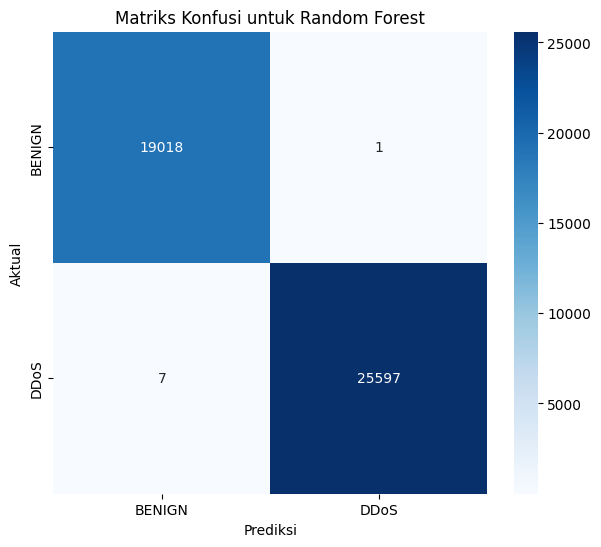


--- Evaluasi Lengkap Model: Gaussian Naive Bayes ---
Akurasi: 0.9893
Presisi: 0.9895
Recall: 0.9893
F1-Score: 0.9893

Laporan Klasifikasi:
               precision    recall  f1-score   support

      BENIGN       1.00      0.98      0.99     19019
        DDoS       0.98      1.00      0.99     25604

    accuracy                           0.99     44623
   macro avg       0.99      0.99      0.99     44623
weighted avg       0.99      0.99      0.99     44623



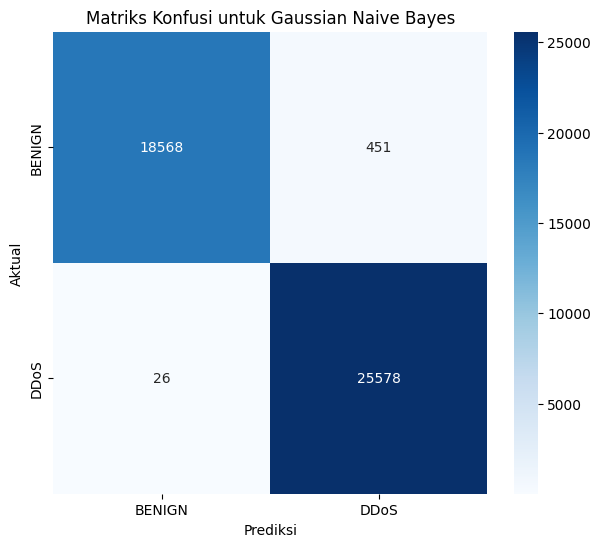


--- Evaluasi Lengkap Model: Neural Network (MLP) ---
Akurasi: 0.9997
Presisi: 0.9997
Recall: 0.9997
F1-Score: 0.9997

Laporan Klasifikasi:
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19019
        DDoS       1.00      1.00      1.00     25604

    accuracy                           1.00     44623
   macro avg       1.00      1.00      1.00     44623
weighted avg       1.00      1.00      1.00     44623



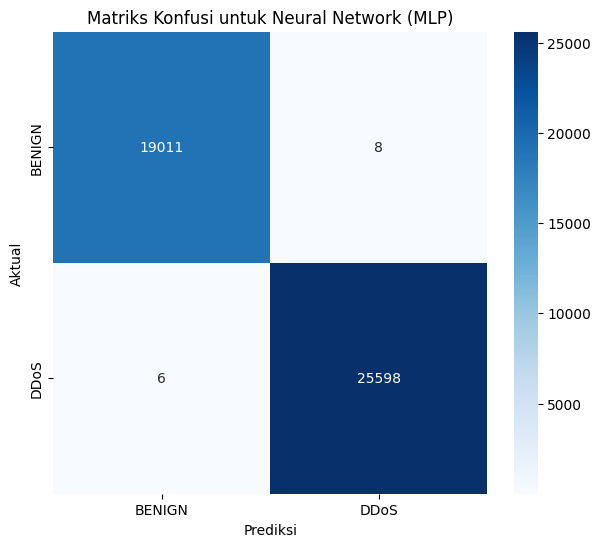

In [23]:
# --- Fungsi untuk Evaluasi dan Visualisasi Lengkap ---
def evaluate_and_plot(y_true, y_pred, model_name, label_encoder):
    print(f"\n--- Evaluasi Lengkap Model: {model_name} ---")

    # Klasifikasi Metrik
    accuracy = accuracy_score(y_true, y_pred)
    # Gunakan zero_division=0 untuk menghindari warning jika ada pembagian oleh nol
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"Akurasi: {accuracy:.4f}")
    print(f"Presisi: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print("\nLaporan Klasifikasi:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))

    # Matriks Konfusi
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f"Matriks Konfusi untuk {model_name}")
    plt.show()

# --- Melakukan Evaluasi Lengkap untuk Setiap Model ---
# Loop ini harus berjalan setelah semua model dilatih dan hasilnya disimpan di 'results'
for model_name, y_pred in results.items():
    evaluate_and_plot(y_test, y_pred, model_name, le)

6.Kesimpulan dan Rekomendasi Model 

In [24]:
print("\n--- Ringkasan Kinerja Model (F1-Score untuk kelas 'DDoS') ---")
if f1_scores_ddos: # Pastikan dictionary tidak kosong
    for model_name, score in f1_scores_ddos.items():
        print(f"- {model_name}: {score:.4f}")

    # Menentukan model terbaik berdasarkan F1-score DDoS
    best_model_name = max(f1_scores_ddos, key=f1_scores_ddos.get)
    best_f1_score_ddos = f1_scores_ddos[best_model_name]

    print(f"\n--- Rekomendasi Model Utama ---")
    print(f"Berdasarkan **F1-score untuk deteksi DDoS** pada dataset ini, model terbaik adalah **{best_model_name}**")
    print(f"dengan F1-score sebesar {best_f1_score_ddos:.4f}.")
    print(f"{best_model_name} biasanya unggul dalam tugas klasifikasi kompleks karena kemampuannya menangani banyak fitur, ketahanan terhadap overfitting, dan kemampuannya untuk mengidentifikasi pola yang rumit dalam data lalu lintas jaringan.")
else:
    print("Tidak ada F1-score DDoS yang tersedia untuk perbandingan. Pastikan model telah dilatih dan dievaluasi dengan benar.")


print("\n--- Kekuatan dan Kelemahan Model ---")
print("\n**Random Forest:**")
print("Kekuatan: Akurasi tinggi, ketahanan terhadap overfitting, mampu menangani fitur yang kompleks dan memberikan feature importance.")
print("Kelemahan: Kurang interpretabel dibanding model sederhana (black box), komputasi lebih berat.")

print("\n**Gaussian Naive Bayes:**")
print("Kekuatan: Sangat cepat, baik sebagai baseline, cocok untuk dataset besar.")
print("Kelemahan: Asumsi independensi fitur yang naif dapat membatasi kinerja jika ada korelasi antar fitur.")

print("\n**Neural Network (MLP):**")
print("Kekuatan: Mampu menangkap pola non-linear dan kompleks, potensi akurasi sangat tinggi jika di-tuning dengan baik.")
print("Kelemahan: 'Black box' (sulit diinterpretasikan), sensitif terhadap hyperparameter, waktu pelatihan bisa lebih lama.")

print("\n--- Tantangan yang Dihadapi Selama Proses Pemodelan dan Evaluasi ---")
print("1. **Ketidakseimbangan Kelas:** Lalu lintas 'BENIGN' mungkin masih lebih dominan, yang dapat menyebabkan model bias dan kurang sensitif terhadap kelas 'DDoS' (serangan).")
print("2. **Skala Fitur yang Berbeda:** Fitur dengan rentang nilai yang sangat bervariasi memerlukan standardisasi untuk kinerja optimal, terutama untuk model seperti Neural Network dan Naive Bayes.")
print("3. **Karakteristik Serangan yang Beragam:** Serangan DDoS bisa memiliki variasi yang signifikan, membuat model harus belajar menggeneralisasi berbagai pola serangan.")

print("\n--- Usulan untuk Peningkatan Kinerja Model di Masa Depan ---")
print("1. **Penanganan Ketidakseimbangan Kelas:** Implementasikan teknik oversampling seperti **SMOTE** pada data pelatihan untuk menyeimbangkan distribusi kelas DDoS.")
print("2. ***Hyperparameter Tuning* Lanjutan:** Gunakan **GridSearchCV** atau **RandomizedSearchCV** dengan *cross-validation* untuk menemukan kombinasi *hyperparameter* optimal yang dapat lebih meningkatkan kinerja model.")
print("3. **Pemilihan Fitur (*Feature Selection*):** Lakukan analisis pentingnya fitur untuk mengidentifikasi dan memilih subset fitur yang paling relevan. Ini dapat mengurangi dimensi data dan mempercepat pelatihan serta inferensi.")
print("4. **Validasi Eksternal:** Uji model pada *dataset* lalu lintas jaringan yang lebih baru atau data *real-time* untuk menilai generalisasi model di skenario dunia nyata.")


--- Ringkasan Kinerja Model (F1-Score untuk kelas 'DDoS') ---
- Random Forest: 0.9998
- Gaussian Naive Bayes: 0.9908
- Neural Network (MLP): 0.9997

--- Rekomendasi Model Utama ---
Berdasarkan **F1-score untuk deteksi DDoS** pada dataset ini, model terbaik adalah **Random Forest**
dengan F1-score sebesar 0.9998.
Random Forest biasanya unggul dalam tugas klasifikasi kompleks karena kemampuannya menangani banyak fitur, ketahanan terhadap overfitting, dan kemampuannya untuk mengidentifikasi pola yang rumit dalam data lalu lintas jaringan.

--- Kekuatan dan Kelemahan Model ---

**Random Forest:**
Kekuatan: Akurasi tinggi, ketahanan terhadap overfitting, mampu menangani fitur yang kompleks dan memberikan feature importance.
Kelemahan: Kurang interpretabel dibanding model sederhana (black box), komputasi lebih berat.

**Gaussian Naive Bayes:**
Kekuatan: Sangat cepat, baik sebagai baseline, cocok untuk dataset besar.
Kelemahan: Asumsi independensi fitur yang naif dapat membatasi kinerja jika